# Fuzzing: Breaking Things with Random Inputs

In this chapter, we'll start with one of the simplest test generation techniques.  The key idea of random text generation, also known as *fuzzing*, is to feed a _string of random characters_ into a program in the hope to uncover failures.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('YjO1pIx7wS4')

**Prerequisites**

* You should know fundamentals of software testing; for instance, from the chapter ["Introduction to Software Testing"](Intro_Testing.ipynb).
* You should have a decent understanding of Python; for instance, from the [Python tutorial](https://docs.python.org/3/tutorial/).


We can make these prerequisites explicit.  First, we'll import a standard package required for working in notebooks.

In [2]:
import bookutils.setup

In [3]:
from typing import Dict, Tuple, Union, List, Any

Now, we explicitly import (and thus require) the earlier chapter.

In [4]:
import Intro_Testing

## Synopsis
To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.Fuzzer import <identifier>
```

and then make use of the following features.

**Note**: The examples in this section only work after the rest of the cells have been executed.


### Fuzzers

`Fuzzer` is a base class for fuzzers, with `RandomFuzzer` as a simple instantiation.  The `fuzz()` method of `Fuzzer` objects returns a string with a generated input.

In [86]:
random_fuzzer = RandomFuzzer()
random_fuzzer.fuzz()

'%$<1&<%+=!"83?+)9:++9138 42/ "7;0-,)06 "1(2;6>?99$%7!!*#96=>2&-/(5*)=$;0$$+;<12"?30&'

The `RandomFuzzer()` constructor allows a number of keyword arguments:

In [87]:
print(RandomFuzzer.__init__.__doc__)

Produce strings of `min_length` to `max_length` characters
in the range [`char_start`, `char_start` + `char_range`)


In [88]:
random_fuzzer = RandomFuzzer(min_length=10, max_length=20, char_start=65, char_range=26)
random_fuzzer.fuzz()

'XGZVDDPZOOW'

In [89]:
# ignore
from ClassDiagram import display_class_hierarchy

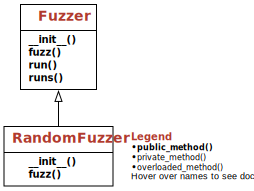

In [90]:
# ignore
display_class_hierarchy(RandomFuzzer,
                        public_methods=[
                            Fuzzer.__init__,
                            Fuzzer.fuzz,
                            Fuzzer.run,
                            Fuzzer.runs,
                            RandomFuzzer.fuzz,
                            RandomFuzzer.__init__,
                        ],
    project='fuzzingbook')

### Runners

A `Fuzzer` can be paired with a `Runner`, which takes the fuzzed strings as input. Its result is a class-specific _status_ and an _outcome_ (`PASS`, `FAIL`, or `UNRESOLVED`). A `PrintRunner` will simply print out the given input and return a `PASS` outcome:

In [91]:
print_runner = PrintRunner()
random_fuzzer.run(print_runner)

EQYGAXPTVPJGTYHXFJ


('EQYGAXPTVPJGTYHXFJ', 'UNRESOLVED')

A `ProgramRunner` will feed the generated input into an external program.  Its result is a pair of the program status (a `CompletedProcess` instance) and an _outcome_ (`PASS`, `FAIL`, or `UNRESOLVED`):

In [92]:
cat = ProgramRunner('cat')
random_fuzzer.run(cat)

(CompletedProcess(args='cat', returncode=0, stdout='BZOQTXFBTEOVYX', stderr=''),
 'PASS')

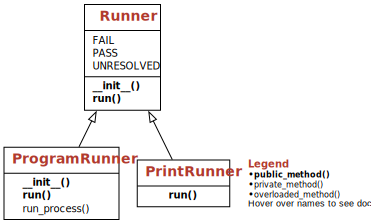

In [93]:
# ignore
display_class_hierarchy([ProgramRunner, PrintRunner],
                        public_methods=[
                            Runner.__init__,
                            Runner.run,
                            ProgramRunner.__init__,
                            ProgramRunner.run,
                            PrintRunner.run
                        ],
    project='fuzzingbook')

## A Testing Assignment

Fuzzing was born in a "dark and stormy night in the Fall of 1988" \cite{Takanen2008}.  Sitting in his apartment in Wisconsin, Madison, professor Barton Miller was connected to his university computer via a 1200 baud telephone line.  The thunderstorm caused noise on the line, and this noise in turn caused the UNIX commands on either end to get bad inputs – and crash.  The frequent crashes surprised him – surely, programs should be more robust than that?  As a scientist, he wanted to investigate the extent of the problem and its causes.  So he crafted a _programming exercise_ for his students at the University of Wisconsin-Madison – an exercise that would have his students create the first fuzzers.

This is how the [assignment](http://pages.cs.wisc.edu/~bart/fuzz/CS736-Projects-f1988.pdf) read:

> The goal of this project is to evaluate the robustness of various UNIX utility programs, given an unpredictable input stream. [...] First, you will build a _fuzz generator_. This is a program that will output a random character stream. Second, you will take the fuzz generator and use it to attack as many UNIX utilities as possible, with the goal of trying to break them.

This assignment captures the essence of fuzzing: _Create random inputs, and see if they break things._  Just let it run long enough, and you'll see.

## A Simple Fuzzer

Let us try to fulfill this assignment and build a fuzz generator.  The idea is to produce random characters, adding them to a buffer string variable (`out`), and finally returning the string.

This implementation uses the following Python features and functions:

* `random.randrange(start, end)` – return a random number $[$ `start`, `end` $)$
* `range(start, end)` – create an iterator (which can be used as a list) with integers in the range $[$ `start`, `end` $)$.
* `for elem in list: body` – execute `body` in a loop with `elem` taking each value from `list`.
* `for i in range(start, end): body` – execute `body` in a loop with `i` from `start` to `end` $-$ 1.
* `chr(n)` – return a character with ASCII code `n`

To use random numbers, we have to import the respective module.

In [5]:
import random

Here comes the actual `fuzzer()` function.

In [6]:
def fuzzer(max_length: int = 100, char_start: int = 32, char_range: int = 32) -> str:
    """A string of up to `max_length` characters
       in the range [`char_start`, `char_start` + `char_range`)"""
    string_length = random.randrange(0, max_length + 1)
    out = ""
    for i in range(0, string_length):
        out += chr(random.randrange(char_start, char_start + char_range))
    return out

With its default arguments, the `fuzzer()` function returns a string of random characters:

In [7]:
fuzzer()

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."'

Bart Miller coined the term "fuzz" as the name for such random, unstructured data.  Now imagine that this "fuzz" string was the input to a program expecting a specific input format – say, a comma-separated list of values, or an e-mail address.  Would the program be able to process such an input without any problems?

If the above fuzzing input already is intriguing, consider that fuzzing can easily be set up to produce other kinds of input.  For instance, we can also have `fuzzer()` produce a series of lowercase letters.  We use `ord(c)` to return the ASCII code of the character `c`.

In [8]:
fuzzer(1000, ord('a'), 26)

'zskscocrxllosagkvaszlngpysurezehvcqcghygphnhonehczraznkibltfmocxddoxcmrvatcleysksodzlwmzdndoxrjfqigjhqjxkblyrtoaydlwwisrvxtxsejhfbnforvlfisojqaktcxpmjqsfsycisoexjctydzxzzutukdztxvdpqbjuqmsectwjvylvbixzfmqiabdnihqagsvlyxwxxconminadcaqjdzcnzfjlwccyudmdfceiepwvyggepjxoeqaqbjzvmjdlebxqvehkmlevoofjlilegieeihmetjappbisqgrjhglzgffqrdqcwfmmwqecxlqfpvgtvcddvmwkplmwadgiyckrfjddxnegvmxravaunzwhpfpyzuyyavwwtgykwfszasvlbwojetvcygectelwkputfczgsfsbclnkzzcjfywitooygjwqujseflqyvqgyzpvknddzemkegrjjrshbouqxcmixnqhgsgdwgzwzmgzfajymbcfezqxndbmzwnxjeevgtpjtcwgbzptozflrwvuopohbvpmpaifnyyfvbzzdsdlznusarkmmtazptbjbqdkrsnrpgdffemnpehoapiiudokczwrvpsonybfpaeyorrgjdmgvkvupdtkrequicexqkoikygepawmwsdcrhivoegynnhodfhryeqbebtbqnwhogdfrsrksntqjbocvislhgrgchkhpaiugpbdygwkhrtyniufabdnqhtnwreiascfvmuhettfpbowbjadfxnbtzhobnxsnf'

Assume a program expects an identifier as its input.  Would it expect such a long identifier?

In [9]:
from bookutils import quiz

In [10]:
quiz("Which of these produces strings with arbitrary long decimal numbers?",
     [
         "`fuzzer(100, 1, 100)`",
         "`fuzzer(100, 100, 0)`",
         "`fuzzer(100, 10, ord('0'))`",
         "`fuzzer(100, ord('0'), 10)`",
     ], "1 ** (2 % 3) * 4")

Indeed! It is the last one that does the trick:

In [11]:
fuzzer(100, ord('0'), 10)

'905902398493166953126081485047020401153418590518545517740565959745145909835837'

## Fuzzing External Programs

Let us see what happens if we actually invoke an external program with fuzzed inputs.  To this end, let us proceed in two steps.  First, we create an _input file_ with fuzzed test data; then we feed this input file into a program of choice.

### Creating Input Files

Let us obtain a temporary file name such that we do not clutter the file system.

In [12]:
import os
import tempfile

In [13]:
basename = "input.txt"
tempdir = tempfile.mkdtemp()
FILE = os.path.join(tempdir, basename)
print(FILE)

/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt


We can now open this file for writing.  The Python `open()` function opens a file into which we can then write arbitrary contents.  It is commonly used in conjunction with the `with` statement, which ensures that the file is closed as soon as it is no longer needed.

In [14]:
data = fuzzer()
with open(FILE, "w") as f:
    f.write(data)

We can verify that the file was actually created by reading its contents:

In [15]:
contents = open(FILE).read()
print(contents)
assert(contents == data)

<?6&" !3'7-5>18%55*,5


### Invoking External Programs

Now that we have an input file, we can invoke a program on it.  For the fun of it, let us test the `bc` calculator program, which takes an arithmetic expression and evaluates it.

To invoke `bc`, let us use the Python `subprocess` module.  This is how this works:


In [16]:
import os
import subprocess

In [17]:
program = "bc"
with open(FILE, "w") as f:
    f.write("2 + 2\n")
result = subprocess.run([program, FILE],
                        stdin=subprocess.DEVNULL,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE,
                        universal_newlines=True)  # Will be "text" in Python 3.7

From the `result`, we can check the program output.  In the case of `bc`, this is the result of evaluating the arithmetic expression:

In [18]:
result.stdout

'4\n'

We can also check the status. A value of 0 indicates that the program terminated correctly.

In [19]:
result.returncode

0

Any error messages would be available in `results.stderr`:

In [20]:
result.stderr

''

Instead of `bc`, you can actually put in any program you like. Be aware, though, that if your program is able to change or even damage your system, there is quite a risk that the fuzzed input contains data or commands that do precisely this.

In [21]:
quiz("Just for the fun of it, imagine you would test a file removal program - "
     "say `rm -fr FILE`, where `FILE` is a string produced by `fuzzer()`. "
     "What is the chance of `fuzzer()` (with default arguments) producing a `FILE` "
     "argument that results in deleting all your files?",
     [
         "About one in a billion",
         "About one in a million",
         "About one in a thousand",
         "About one in ten"
     ], "9 ** 0.5")

The chance is actually higher than you may think. If you remove `/` (the root of all files), for instance, your entire file system will be gone. If you remove `.` (the current folder), all the files in the current directory will be gone. 

The probability of generating a string that is exactly 1 character long is 1/101, this is because the length of the string is determined by calling random.randrange(0, max_length + 1), where the default value of max_length is 100. Per the description given of random.randrange, that should return a random number in [0, 99 + 1). So, we end up with the inclusive range [0, 100] where there are 101 values in the interval.

For `/` or `.` to be produced, you need a string length of 1 (chance: 1 out of 101) and one of these two characters (chance: 2 out of 32).

In [22]:
1/101 * 2/32

0.0006188118811881188

The above code block precludes the possibility of removing `~` (your home directory), this is because the probability of generating the character '~' is not 1/32; it is 0/32. The characters are created by calling chr(random.randrange(char_start, char_start + char_range)), where the default value of char_start is 32 and the default value of char_range is 32. The documentation for chr reads, "[r]eturn the string representing a character whose Unicode code point is the integer i." The Unicode code point for '~' is 126 and therefore, not in the interval [32, 64). 

If the code were to be changed so that char_range = 95 then the probability of obtaining the character '~' would be 1/94 , thus resulting in the probability of the event of deleting all files being equal to 0.000332

And all your files in the home directory will be gone

In [23]:
3/94 * 1/94 * 99/101

0.0003327969736765437

However, we can actually deal with any string as long as the _second_ character is a space – after all, `rm -fr / WHATEVER` will first deal with `/`, and only then with whatever follows. The chances for the first character are 2 out of 32 as the code block above only allows for the probability of obtaining a `/` or a `.` but not a `~`.

For the space the probability is 1 out of 32.

We have to include the term for the probability of obtaining at least 2 characters which is required for the scenario of obtaining a space as the second character. This probability is 99/101 because it is calculated as (1 - probability of obtaining a single character or no character at all), so it is equal to 1-(2/101).

Therefore, the probability calculation for the event of deleting all files in the case of having a space for the second character is:

[probability of obtaining '/' or '. ' followed by a space] = [the probability of obtaining either the '/' character or the '. ' character] * [the probability of obtaining space] * [Probability of getting at least 2 characters] = 0.001914



Diagram of probability of obtaining at least 2 characters.

In [24]:
2/32 * 1/32 * 99/101

0.0019144492574257425

Given that fuzz tests are typically run millions of times, you really don't want to take this risk. Run your fuzzers in a safe environment that you can reset at will, such as a Docker container.

### Long-Running Fuzzing

Let us now feed a large number of inputs into our tested program, to see whether it might crash on some.  We store all results in the `runs` variable as pairs of input data and the actual result. (Note: running this may take a while.)

In [25]:
trials = 100
program = "bc"

runs = []

for i in range(trials):
    data = fuzzer()
    with open(FILE, "w") as f:
        f.write(data)
    result = subprocess.run([program, FILE],
                            stdin=subprocess.DEVNULL,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE,
                            universal_newlines=True)
    runs.append((data, result))

We can now query `runs` for some statistics.  For instance, we can query how many runs actually passed -- that is, there were no error messages.  We use a _list comprehension_ here: The form _expression_ `for` _element_ `in` _list_ `if` _condition_ returns a list of evaluated _expressions_ in which each _element_ comes from _list_ if the _condition_ was true.  (Actually, a list comprehension returns a _list generator_, but for our purposes, the generator behaves like a list.)  Here, we have the _expression_ be 1 for all elements where _condition_ holds, and we use `sum()` to sum over all elements in the list.

In [26]:
sum(1 for (data, result) in runs if result.stderr == "")

9

Most inputs apparently are invalid – not a big surprise, as it is unlikely that a random input contains a valid arithmetic expression.

Let us take a look at the first error message: 

In [27]:
errors = [(data, result) for (data, result) in runs if result.stderr != ""]
(first_data, first_result) = errors[0]

print(repr(first_data))
print(first_result.stderr)

'5&8>"86,?"/7!1%5-**&-$&)$91;"21(\'8"(%$4,("(&!67%89$!.?(*(96(28$=6029:<:$(6 !-+2622(&4'

Parse error: bad character '&'
    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1




Are there any runs with messages other than `illegal character`, `parse error`, or `syntax error`?  (Say, something like `crash` or `you found a fatal bug`?)  Not very many:

In [28]:
[result.stderr for (data, result) in runs if
 result.stderr != ""
 and "illegal character" not in result.stderr
 and "parse error" not in result.stderr
 and "syntax error" not in result.stderr]

["\nParse error: bad character '&'\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n",
 '\nParse error: bad expression\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad expression\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad token\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad token\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad token\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad token\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad token\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr43ss/input.txt:1\n\n',
 '\nParse error: bad expression\n    /var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp97hr4

Maybe a crash would be indicated by `bc` just crashing.  Unfortunately, the return code is never nonzero:

In [29]:
sum(1 for (data, result) in runs if result.returncode != 0)

91

How about we let the above `bc` test run for some more?  While it is running, let us take a look on how the state of the art was in 1989.

## Bugs Fuzzers Find

When Miller and his students ran their first fuzzers in 1989, they found an alarming result: About **a third of the UNIX utilities** they fuzzed had issues – they crashed, hung, or otherwise failed when confronted with fuzzing input \cite{Miller1990}.  This also included the `bc` program, above.  (The `bc` above is a [modern reimplementation](https://git.gavinhoward.com/gavin/bc) whose author is a [staunch believer in fuzzing](https://git.gavinhoward.com/gavin/bc/src/branch/master/tests/fuzzing)!)

Considering that many of these UNIX utilities were used in scripts that would also process network input, this was an alarming result.  Programmers quickly built and ran their own fuzzers, rushed to fix the reported errors, and learned not to trust external inputs anymore.

What kind of problems did Miller's fuzzing experiment find?  It turns out that the mistakes programmers made in 1990 are still the same mistakes being made today.


### Buffer Overflows

Many programs have built-in maximum lengths for inputs and input elements.  In languages like C, it is easy to excess these lengths without the program (or the programmer) even noticing, triggering so-called **buffer overflows**.  The following code, for instance, happily copies the `input` string into a `weekday` string even if `input` has more than eight characters:
```c
char weekday[9]; // 8 characters + trailing '\0' terminator
strcpy (weekday, input);
```
Ironically, this already fails if `input` is `"Wednesday"` (9 characters); any excess characters (here, `'y'` and the following `'\0'` string terminator) are simply copied to whatever resides in memory after `weekday`, triggering arbitrary behavior; maybe some boolean character variable which would be set from `'n'` to `'y'`.  With fuzzing, it is very easy to produce arbitrary long inputs and input elements.

We can easily simulate this buffer overflow behavior in a Python function:

In [30]:
def crash_if_too_long(s):
    buffer = "Thursday"
    if len(s) > len(buffer):
        raise ValueError

And yes, it quickly crashes.

In [31]:
from ExpectError import ExpectError

In [32]:
trials = 100
with ExpectError():
    for i in range(trials):
        s = fuzzer()
        crash_if_too_long(s)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/292568387.py", line 5, in <module>
    crash_if_too_long(s)
    ~~~~~~~~~~~~~~~~~^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/2784561514.py", line 4, in crash_if_too_long
    raise ValueError
ValueError (expected)


The `with ExpectError()` line in the above code ensures that the error message is printed, yet execution continues; this is to differentiate this "expected" error from "unexpected" errors in other code examples.

### Missing Error Checks

Many programming languages do not have exceptions, but instead have functions return special **error codes** in exceptional circumstances.  The C function `getchar()`, for instance, normally returns a character from the standard input; if no input is available anymore, it returns the special value `EOF` (end of file).  Now assume a programmer is scanning the input for the next character, reading in characters with `getchar()` until a space character is read:
```c
while (getchar() != ' ');
```
What happens if the input ends prematurely, as would perfectly be feasible with fuzzing?  Well, `getchar()` returns `EOF`, and keeps on returning `EOF` when called again; so the code above simply enters an infinite loop.

Again, we can simulate such missing error checks.  Here's a function that will effectively hang if no space is present in the input:

In [33]:
def hang_if_no_space(s):
    i = 0
    while True:
        if i < len(s):
            if s[i] == ' ':
                break
        i += 1

Using the timeout mechanism from our [Introduction to Testing](Intro_Testing.ipynb), we can interrupt this function after some time.  And yes, it does hang after a few fuzzing inputs.

In [34]:
from ExpectError import ExpectTimeout

In [35]:
trials = 100
with ExpectTimeout(2):
    for i in range(trials):
        s = fuzzer()
        hang_if_no_space(s)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/3194687366.py", line 5, in <module>
    hang_if_no_space(s)
    ~~~~~~~~~~~~~~~~^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/3035466707.py", line 3, in hang_if_no_space
    while True:
          ^^^^
  File "Timeout.ipynb", line 43, in timeout_handler
    raise TimeoutError()
TimeoutError (expected)


The `with ExpectTimeout()` line in the above code ensures that execution of the enclosed code is interrupted after two seconds, printing the error message.


### Rogue Numbers

With fuzzing, it is easy to generate **uncommon values** in the input, causing all kinds of interesting behavior.  Consider the following code, again in the C language, which first reads a buffer size from the input, and then allocates a buffer of the given size:
```c
char *read_input() {
    size_t size = read_buffer_size();
    char *buffer = (char *)malloc(size);
    // fill buffer
    return (buffer);
}
```
What happens if `size` is very large, exceeding program memory?  What happens if `size` is less than the number of characters following?  What happens if `size` is negative?  By providing a random number here, fuzzing can create all kinds of damages.


Again, we can easily simulate such rogue numbers in Python.  The function `collapse_if_too_large()` fails if the passed value (a string) is too large after having been converted to an integer.

In [36]:
def collapse_if_too_large(s):
    if int(s) > 1000:
        raise ValueError

We can have `fuzzer()` create a string of digits:

In [37]:
long_number = fuzzer(100, ord('0'), 10)
print(long_number)

7056414967099541967374507745748918952640135045


If we feed such numbers into `collapse_if_too_large()`, it will very soon fail.

In [38]:
with ExpectError():
    collapse_if_too_large(long_number)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/2775103647.py", line 2, in <module>
    collapse_if_too_large(long_number)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/1591744602.py", line 3, in collapse_if_too_large
    raise ValueError
ValueError (expected)


If we really wanted to allocate that much memory on a system, having it quickly fail as above actually would be the better option.  In reality, running out of memory may dramatically slow systems down, up to the point that they become totally unresponsive – and restarting is the only option.

One might argue that these are all problems of bad programming, or of bad programming languages.  But then, there are thousands of people starting to program every day, and all of them make the same mistakes again and again, even today.  

## Catching Errors

When Miller and his students built their first fuzzer, they could identify errors simply because the program would crash or hang – two conditions that are easy to identify.  If the failures are more subtle, though, we need to come up with additional checks.

### Generic Checkers

Buffer overflows, as [discussed above](#Buffer-Overflows), are a particular instance of a more general problem: In languages like C and C++, a program can access arbitrary parts of its memory – even those parts that are uninitialized, already freed or simply not part of the data structure you are trying to access.  This is necessary if you want to write an operating system, and great if you want a maximum of performance or control, but pretty bad if you want to avoid mistakes.  Fortunately, there are tools that help catching such issues at runtime, and they are great when combined with fuzzing.

#### Checking Memory Accesses

To catch problematic memory accesses during testing, one can run C programs in special _memory-checking_ environments; at runtime, these check for each and every memory operation whether it accesses valid and initialized memory. A popular example is [LLVM Address Sanitizer](https://clang.llvm.org/docs/AddressSanitizer.html) which detects a whole set of potentially dangerous memory safety violations. In the following example we will compile a rather simple C program with this tool and provoke an out-of-bounds read by reading past an allocated portion of memory.

In [39]:
with open("program.c", "w") as f:
    f.write("""
#include <stdlib.h>
#include <string.h>

int main(int argc, char** argv) {
    /* Create an array with 100 bytes, initialized with 42 */
    char *buf = malloc(100);
    memset(buf, 42, 100);

    /* Read the N-th element, with N being the first command-line argument */
    int index = atoi(argv[1]);
    char val = buf[index];

    /* Clean up memory so we don't leak */
    free(buf);
    return val;
}
    """)

In [40]:
from bookutils import print_file

In [41]:
print_file("program.c")

#include <stdlib.h>
#include <string.h>

int main(int argc, char** argv) {
    /* Create an array with 100 bytes, initialized with 42 */
    char *buf = malloc(100);
    memset(buf, 42, 100);

    /* Read the N-th element, with N being the first command-line argument */
    int index = atoi(argv[1]);
    char val = buf[index];

    /* Clean up memory so we don't leak */
    free(buf);
    return val;
}
    

We compile this C program with address sanitization enabled:

In [42]:
!clang -fsanitize=address -g -o program program.c

If we run the program with an argument of `99`, it returns `buf[99]`, which is 42.

In [43]:
!./program 99; echo $?

42


Accessing `buf[110]`, however, results in an out-of-bounds error in AddressSanitizer.

In [44]:
!./program 110

==63288==ERROR: AddressSanitizer: heap-buffer-overflow on address 0x60b0000000ae at pc 0x000104780668 bp 0x00016b67e6e0 sp 0x00016b67e6d8
READ of size 1 at 0x60b0000000ae thread T0


    #0 0x000104780664 in main program.c:12
    #1 0x0001870c1d50 in start+0x1c0c (dyld:arm64e+0x3d50)

0x60b0000000ae is located 10 bytes after 100-byte region [0x60b000000040,0x60b0000000a4)
allocated by thread T0 here:
    #0 0x000104e8530c in malloc+0x78 (libclang_rt.asan_osx_dynamic.dylib:arm64e+0x3d30c)
    #1 0x0001047805c0 in main program.c:7
    #2 0x0001870c1d50 in start+0x1c0c (dyld:arm64e+0x3d50)

SUMMARY: AddressSanitizer: heap-buffer-overflow program.c:12 in main
Shadow bytes around the buggy address:
  0x60affffffe00: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x60affffffe80: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x60afffffff00: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x60afffffff80: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x60b000000000: fa fa fa fa fa fa fa fa 00 00 00 00 00 00 00 00
=>0x60b000000080: 00 00 00 00 04[fa]fa fa fa fa fa fa fa fa fa fa
  0x60b000000100: fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa
  0x60b000000180: 

If you want to find errors in a C program, turning on such checks for fuzzing is fairly easy.  It will slow down execution by a certain factor depending on the tool (for AddressSanitizer it is typically 2$\times$) and also consume more memory, but CPU cycles are dead cheap compared to the human effort it takes to find these bugs.

Out-of-bounds accesses to memory are a great security risk, as they may let attackers access or even modify information that is not meant for them.  As a famous example, the [HeartBleed bug](https://en.wikipedia.org/wiki/Heartbleed) was a security bug in the OpenSSL library, implementing cryptographic protocols that provide communications security over a computer network.  (If you read this text in a browser, it is likely encrypted using these protocols.)

The HeartBleed bug was exploited by sending a specially crafted command to the SSL *heartbeat* service.  A heartbeat service is used to check if the server on the other end is still alive.  A client would send the service a string like

```
BIRD (4 letters)
```

to which the server would reply with `BIRD`, and the client would know the server is alive.

Unfortunately, this service could be exploited by asking the server to reply with _more_ than the requested set of letters.  This is very well explained in this [XKCD comic](https://xkcd.com/1354/):

![XKCD Comic](PICS/xkcd_heartbleed_1.png)

![XKCD Comic](PICS/xkcd_heartbleed_2.png)

![XKCD Comic](PICS/xkcd_heartbleed_3.png)

In the OpenSSL implementation, these memory contents could involve cryptographic certificates, private keys, and more – and worse, no one would notice that this memory just had been accessed.  When the HeartBleed bug was discovered, it had been around for many years, and none would know whether and which secrets had already leaked; the quickly set up [HeartBleed announcement page](http://heartbleed.com/) said it all.

But how was HeartBleed discovered?  Very simple.  Researchers both at the Codenomicon company as well as with Google compiled the OpenSSL library with a memory sanitizer, and then happily flooded it with fuzzed commands.  The memory sanitizer would then notice whether an out-of-bounds memory access had occurred – and actually, it would very quickly discover this.

A memory checker is just one of many checkers one can run to detect runtime errors during fuzzing.  In the [chapter on mining function specifications](DynamicInvariants.ipynb), we will learn more about how to define generic checkers.

We're done with `program`, so we clean up:

In [45]:
!rm -fr program program.*

#### Information Leaks

Information leaks may not only occur through illegal memory accesses; they can also occur within "valid" memory – if this "valid" memory contains sensitive information that should not leak out.  Let us illustrate this issue in a Python program.  To start with, let us create some program memory filled with actual data and random data:

In [46]:
secrets = ("<space for reply>" + fuzzer(100) +
           "<secret-certificate>" + fuzzer(100) +
           "<secret-key>" + fuzzer(100) + "<other-secrets>")

We add more "memory" characters to `secrets`, filled with `"deadbeef"` as marker for uninitialized memory:

In [47]:
uninitialized_memory_marker = "deadbeef"
while len(secrets) < 2048:
    secrets += uninitialized_memory_marker

We define a service (similar to the heartbeat service discussed above) that would take a reply to be sent back, as well as a length.  It would store the reply to be sent in memory, and then send it back with the given length.

In [48]:
def heartbeat(reply: str, length: int, memory: str) -> str:
    # Store reply in memory
    memory = reply + memory[len(reply):]

    # Send back heartbeat
    s = ""
    for i in range(length):
        s += memory[i]
    return s

This perfectly works for standard strings:

In [49]:
heartbeat("potato", 6, memory=secrets)

'potato'

In [50]:
heartbeat("bird", 4, memory=secrets)

'bird'

However, if the length is greater than the length of the reply string, additional contents of memory spill out.  Note that all of this still occurs within regular array bounds, so an address sanitizer would not be triggered:

In [51]:
heartbeat("hat", 500, memory=secrets)

'hatace for reply>#,,!3?30>#61)$4--8=<7)4 )03/%,5+! "4)0?.9+?3();<42?=?0<secret-certificate>7(+/+((1)#/0\'4!>/<#=78%6$!!$<-"3"\'-?1?85!05629%/); *)1\'/=9%<secret-key>.(#.4%<other-secrets>deadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadb'

How can one detect such issues?  The idea is to identify information that should not leak out, such as the given secrets, but also uninitialized memory.  We can simulate such a check in a small Python example:

In [52]:
from ExpectError import ExpectError

In [53]:
with ExpectError():
    for i in range(10):
        s = heartbeat(fuzzer(), random.randint(1, 500), memory=secrets)
        assert not s.find(uninitialized_memory_marker)
        assert not s.find("secret")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/4040656327.py", line 4, in <module>
    assert not s.find(uninitialized_memory_marker)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError (expected)


With such a check, we find that secrets and/or uninitialized memory indeed leak out.  In the [chapter on information flow](InformationFlow.ipynb), we will discuss how to do this automatically, "tainting" sensitive information and values derived from them, and ensuring that "tainted" values do not leak out.

As a rule of thumb, you should always _enable as many automatic checkers as possible_ during fuzzing.  CPU cycles are cheap, and errors are expensive.  If you only execute the program without an option to actually detect errors, you will be missing several opportunities.

### Program-Specific Checkers

Besides generic checkers that apply to _all_ programs on a given platform or in a given language, you can also devise _specific_ checkers that apply to your program, or a subsystem.  In the [chapter on testing](Intro_Testing.ipynb), we already have hinted at techniques of [runtime verification](Intro_Testing.ipynb#Runtime-Verification) that check function results at runtime for correctness.

One key idea for detecting errors early is the concept of *assertion* – a predicate that checks the input (precondition) and the result (postcondition) of important functions.  The more assertions you have in your program, the higher your chances to detect errors during execution that would go undetected by generic checkers – notably during fuzzing.  If you worry about the impact of assertions on performance, keep in mind that assertions can be turned off in production code (although it can be helpful to leave the most critical checks active).

One of the most important uses of assertions for finding errors is _checking the integrity of complex data structures._  Let us illustrate the concept using a simple example.  Suppose we have a mapping of airport codes to airports, as in

In [54]:
airport_codes: Dict[str, str] = {
    "YVR": "Vancouver",
    "JFK": "New York-JFK",
    "CDG": "Paris-Charles de Gaulle",
    "CAI": "Cairo",
    "LED": "St. Petersburg",
    "PEK": "Beijing",
    "HND": "Tokyo-Haneda",
    "AKL": "Auckland"
}  # plus many more

In [55]:
airport_codes["YVR"]

'Vancouver'

In [56]:
"AKL" in airport_codes

True

This list of airport codes may be pretty critical: if we have a spelling mistake in any of the airport codes, this may impact whatever application we have.  We therefore introduce a function that checks the list for consistency.  The consistency condition is called a *representation invariant*, and functions (or methods) that check it are therefore typically named `repOK()` for "the representation is ok".

First, let's have a checker for individual airport codes.  The checker fails if the code is inconsistent.

In [57]:
def code_repOK(code: str) -> bool:
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
    for c in code:
        assert c.isalpha(), "Non-letter in airport code: " + repr(code)
        assert c.isupper(), "Lowercase letter in airport code: " + repr(code)
    return True

In [58]:
assert code_repOK("SEA")

We can now use `code_repOK()` to check all elements in the list:

In [59]:
def airport_codes_repOK():
    for code in airport_codes:
        assert code_repOK(code)
    return True

In [60]:
with ExpectError():
    assert airport_codes_repOK()

If we add an invalid element to the list, our check would fail:

In [61]:
airport_codes["YMML"] = "Melbourne"

In [62]:
with ExpectError():
    assert airport_codes_repOK()

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/2308942452.py", line 2, in <module>
    assert airport_codes_repOK()
           ~~~~~~~~~~~~~~~~~~~^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/480627665.py", line 3, in airport_codes_repOK
    assert code_repOK(code)
           ~~~~~~~~~~^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/865020192.py", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
           ^^^^^^^^^^^^^^
AssertionError: Airport code must have three characters: 'YMML' (expected)


Of course, rather than manipulating the list directly, we'd have a special function for adding elements; this could then also check whether the code is valid:

In [63]:
def add_new_airport(code: str, city: str) -> None:
    assert code_repOK(code)
    airport_codes[code] = city

In [64]:
with ExpectError():  # For BER, ExpectTimeout would be more appropriate
    add_new_airport("BER", "Berlin")

This check also allows us to find out errors in argument lists:

In [65]:
with ExpectError():
    add_new_airport("London-Heathrow", "LHR")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/1427835309.py", line 2, in <module>
    add_new_airport("London-Heathrow", "LHR")
    ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/2655039924.py", line 2, in add_new_airport
    assert code_repOK(code)
           ~~~~~~~~~~^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/865020192.py", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
           ^^^^^^^^^^^^^^
AssertionError: Airport code must have three characters: 'London-Heathrow' (expected)


For maximum checking, though, the `add_new_airport()` function would also ensure the correct representation of the list of airport codes – _before_ and _after_ changing it.

In [66]:
def add_new_airport_2(code: str, city: str) -> None:
    assert code_repOK(code)
    assert airport_codes_repOK()
    airport_codes[code] = city
    assert airport_codes_repOK()

This catches the inconsistency introduced earlier:

In [67]:
with ExpectError():
    add_new_airport_2("IST", "Istanbul Yeni Havalimanı")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/1096579022.py", line 2, in <module>
    add_new_airport_2("IST", "Istanbul Yeni Havalimanı")
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/2099116665.py", line 3, in add_new_airport_2
    assert airport_codes_repOK()
           ~~~~~~~~~~~~~~~~~~~^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/480627665.py", line 3, in airport_codes_repOK
    assert code_repOK(code)
           ~~~~~~~~~~^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/865020192.py", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
           ^^^^^^^^^^^^^^
AssertionError: Airport code must have three characters: 'YMML' (expected)


The more `repOK()` assertions exist in your code, the more errors you will catch – even those specific to only your domain and problem.  On top, such assertions document the _assumptions you made_ during programming and thus help other programmers to understand your code and prevent errors.

As a final example, let us consider a rather complex data structure – a [red-black tree](https://en.wikipedia.org/wiki/Red-black_tree), a self-balancing binary search tree.  Implementing a red-black tree is not too hard, but getting it correct can be a task of several hours even for experienced programmers.  A `repOK()` method, however, documents all the assumptions and checks them as well:

In [68]:
class RedBlackTree:
    def repOK(self):
        assert self.rootHasNoParent()
        assert self.rootIsBlack()
        assert self.rootNodesHaveOnlyBlackChildren()
        assert self.treeIsAcyclic()
        assert self.parentsAreConsistent()
        return True

    def rootIsBlack(self):
        if self.parent is None:
            assert self.color == BLACK
        return True

    def add_element(self, elem):
        assert self.repOK()
        ...  # Add the element
        assert self.repOK()

    def delete_element(self, elem):
        assert self.repOK()
        ...  # Delete the element
        assert self.repOK()

Here, `repOK()` is a method that runs on an object of the `RedBlackTree` class.  It runs five different checks, all of which have their own assertions.  Whenever an element is added or deleted, all these consistency checks are run automatically.  If you have an error in any of these, the checkers will find them – if you run the tree through sufficiently many fuzzed inputs, of course.

### Static Code Checkers

Many of the benefits from `repOK()` assertions can also be obtained by using _static type checkers_ on your code.  In Python, for instance, the [MyPy](http://mypy-lang.org) static checker can find type errors as soon as types of arguments are properly declared:

In [69]:
typed_airport_codes: Dict[str, str] = {
    "YVR": "Vancouver",  # etc
}

If we now add a key with a non-string type, as in

In [70]:
typed_airport_codes[1] = "First"  # type: ignore

this would be caught by MyPy immediately:
```sh
$ mypy airports.py
airports.py: error: Invalid index type "int" for "Dict[str, str]"; expected type "str"
```

Statically checking more advanced properties such as the airport code consisting of exactly three uppercase characters or a tree being acyclic, however, quickly reach the limits of static checking.  Your `repOK()` assertions will still be needed – best in conjunction with a good test generator.

## A Fuzzing Architecture

Since we'd like to reuse some parts of this chapter in the following ones, let us define things in a way that are easier to reuse, and in particular easier to _extend_.  To this end, we introduce a number of _classes_ that encapsulate the functionality above in a reusable way. 

### Runner Classes

The first thing we introduce is the notion of a `Runner` – that is, an object whose job it is to execute some object with a given input.  A runner typically is some program or function under test, but we can also have simpler runners.

Let us start with a base class for runners.  A runner essentially provides a method `run(input)` that is used to pass `input` (a string) to the runner.  `run()` returns a pair (`result`, `outcome`).  Here, `result` is a runner-specific value that gives details on the run; `outcome` is a value that classifies the result in three categories:

* `Runner.PASS` – the test _passed_.  The run produced correct results.
* `Runner.FAIL` – the test _failed_.  The run produced incorrect results.
* `Runner.UNRESOLVED` – the test neither passed nor failed.  This happens if the run could not take place – for instance, because the input was invalid.

In [71]:
Outcome = str

In [72]:
class Runner:
    """Base class for testing inputs."""

    # Test outcomes
    PASS = "PASS"
    FAIL = "FAIL"
    UNRESOLVED = "UNRESOLVED"

    def __init__(self) -> None:
        """Initialize"""
        pass

    def run(self, inp: str) -> Any:
        """Run the runner with the given input"""
        return (inp, Runner.UNRESOLVED)

As a base class, `Runner` merely provides an interface for more complex runners that build on it.  More specifically, we introduce *subclasses* that *inherit* the methods from their superclass in order to add additional methods or to override inherited methods.

Here is one example of such a subclass: `PrintRunner` simply prints out everything that is given to it, overriding the inherited `run()` method.  This is the default runner in many situations.

In [73]:
class PrintRunner(Runner):
    """Simple runner, printing the input."""

    def run(self, inp) -> Any:
        """Print the given input"""
        print(inp)
        return (inp, Runner.UNRESOLVED)

In [74]:
p = PrintRunner()
(result, outcome) = p.run("Some input")

Some input


The result is just the string we passed as input:

In [75]:
result

'Some input'

Still, at this point, we have no way to classify program behavior:

In [76]:
outcome

'UNRESOLVED'

The `ProgramRunner` class sends the input to the standard input of a program instead.  The program is specified when creating a `ProgramRunner` object.

In [77]:
class ProgramRunner(Runner):
    """Test a program with inputs."""

    def __init__(self, program: Union[str, List[str]]) -> None:
        """Initialize.
           `program` is a program spec as passed to `subprocess.run()`"""
        self.program = program

    def run_process(self, inp: str = "") -> subprocess.CompletedProcess:
        """Run the program with `inp` as input.
           Return result of `subprocess.run()`."""
        return subprocess.run(self.program,
                              input=inp,
                              stdout=subprocess.PIPE,
                              stderr=subprocess.PIPE,
                              universal_newlines=True)

    def run(self, inp: str = "") -> Tuple[subprocess.CompletedProcess, Outcome]:
        """Run the program with `inp` as input.  
           Return test outcome based on result of `subprocess.run()`."""
        result = self.run_process(inp)

        if result.returncode == 0:
            outcome = self.PASS
        elif result.returncode < 0:
            outcome = self.FAIL
        else:
            outcome = self.UNRESOLVED

        return (result, outcome)

Here's a variant for binary (i.e., non-textual) input and output.

In [78]:
class BinaryProgramRunner(ProgramRunner):
    def run_process(self, inp: str = "") -> subprocess.CompletedProcess:
        """Run the program with `inp` as input.  
           Return result of `subprocess.run()`."""
        return subprocess.run(self.program,
                              input=inp.encode(),
                              stdout=subprocess.PIPE,
                              stderr=subprocess.PIPE)

Let us demonstrate a `ProgramRunner` using the `cat` program – a program that copies its input to its output.  We see that a standard invocation of `cat` simply does the job, with the output of `cat` being the same as its input:

In [79]:
cat = ProgramRunner(program="cat")
cat.run("hello")

(CompletedProcess(args='cat', returncode=0, stdout='hello', stderr=''), 'PASS')

### Fuzzer Classes

Let us now define a *fuzzer* that actually feed data into a consumer.  The base class for fuzzers provides one central method `fuzz()` that creates some input.  The `run()` function then sends the fuzz() input to a runner, returning the outcome; `runs()` does this for a given number (`trials`) of times.

In [80]:
class Fuzzer:
    """Base class for fuzzers."""

    def __init__(self) -> None:
        """Constructor"""
        pass

    def fuzz(self) -> str:
        """Return fuzz input"""
        return ""

    def run(self, runner: Runner = Runner()) \
            -> Tuple[subprocess.CompletedProcess, Outcome]:
        """Run `runner` with fuzz input"""
        return runner.run(self.fuzz())

    def runs(self, runner: Runner = PrintRunner(), trials: int = 10) \
            -> List[Tuple[subprocess.CompletedProcess, Outcome]]:
        """Run `runner` with fuzz input, `trials` times"""
        return [self.run(runner) for i in range(trials)]

By default, `Fuzzer` objects do not do much, as their `fuzz()` function is merely an abstract placeholder.  The subclass `RandomFuzzer`, however, implements the functionality of the `fuzzer()` function, above, adding a parameter `min_length` to specify a minimum length.

In [81]:
class RandomFuzzer(Fuzzer):
    """Produce random inputs."""

    def __init__(self, min_length: int = 10, max_length: int = 100,
                 char_start: int = 32, char_range: int = 32) -> None:
        """Produce strings of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`)"""
        self.min_length = min_length
        self.max_length = max_length
        self.char_start = char_start
        self.char_range = char_range

    def fuzz(self) -> str:
        string_length = random.randrange(self.min_length, self.max_length + 1)
        out = ""
        for i in range(0, string_length):
            out += chr(random.randrange(self.char_start,
                                        self.char_start + self.char_range))
        return out

With `RandomFuzzer`, we can now create a fuzzer whose configuration needs to be specified only once when creating the fuzzer.

In [82]:
random_fuzzer = RandomFuzzer(min_length=20, max_length=20)
for i in range(10):
    print(random_fuzzer.fuzz())

'>23>33)(&"09.377.*3
*+:5 ? (?1$4<>!?3>.'
4+3/(3 (0%!>!(+9%,#$
/51$2964>;)2417<9"2&
907.. !7:&--"=$7',7*
(5=5'.!*+&>")6%9)=,/
?:&5) ";.0!=6>3+>)=,
6&,?:!#2))- ?:)=63'-
,)9#839%)?&(0<6("*;)
4?!(49+8=-'&499%?< '


We can now send such generated inputs to our previously defined `cat` runner, verifying that `cat` actually does copy its (fuzzed) input to its output.

In [83]:
for i in range(10):
    inp = random_fuzzer.fuzz()
    result, outcome = cat.run(inp)
    assert result.stdout == inp
    assert outcome == Runner.PASS

Combining a `Fuzzer` with a `Runner`, however, is so common that we can use the `run()` method supplied by the `Fuzzer` class for this purpose:

In [84]:
random_fuzzer.run(cat)

(CompletedProcess(args='cat', returncode=0, stdout='?:+= % <1<6$:(>=:9)5', stderr=''),
 'PASS')

With `runs()`, we can repeat a fuzzing run a number of times, obtaining a list of results.

In [85]:
random_fuzzer.runs(cat, 10)

[(CompletedProcess(args='cat', returncode=0, stdout='3976%%&+%6=(1)3&3:<9', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='33$#42$ 11=*%$20=<.-', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='"?<\'#8 </:*%9.--\'97!', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="/0-#(03/!#60'+6>&&72", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="=,+:,6'5:950+><3(*()", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout=" 379+0?'%3137=2:4605", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="02>!$</'*81.#</22>+:", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="=-<'3-#88*%&*9< +1&&", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='2;;0=3&6=8&30&<-;?*;', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='/#05=*3($>::#7!0=12+', stderr=''),
  'PASS')]

With this, we have all in place to create fuzzers – starting with the simple random fuzzers introduced in this chapter, but even far more advanced ones.  Stay tuned!

## Lessons Learned

* Randomly generating inputs ("fuzzing") is a simple, cost-effective way to quickly test arbitrary programs for their robustness.
* Bugs fuzzers find are mainly due to errors and deficiencies in _input processing_.
* To catch errors, have as many _consistency checkers_ as possible.

We're done, so don't forget to clean up:

In [94]:
os.remove(FILE)
os.removedirs(tempdir)

## Next Steps

From here, you can explore how to

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ to specify the input format and thus get many more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)

Enjoy the read!

## Background

Books on generating software tests in general are scarce (which is why we wrote this book).  There are a few notable books on _fuzzing,_ though, also based on the basic fuzzing techniques introduced in this chapter:

* The book "Fuzzing – Brute Force Vulnerability Discovery"  covers a wide range of fuzzing domains, including files, Web pages, environment variables, and network protocols.  The authors bring in lots of experience from fuzzing at Microsoft, and include a number of ready-made tools for Windows and UNIX programs.  The tools have aged somewhat, but the principles remain.

* The book "Fuzzing for Software Security Testing and Quality Assurance" \cite{Takanen2008}, now in its second edition 2018, covers a wide range of fuzzing tools and detection techniques; its authors bring in plenty of experience from security testing and vulnerability discovery.  This is arguably one of the most comprehensive and up-to-date books on the field.

Specifically for this chapter, the seminal work on fuzzing, introducing both the term and the approach, is "An Empirical Study of the Reliability of UNIX Utilities" \cite{Miller1990}.  As the foundation for the field, this is a must-read for anyone interested in fuzzing and robustness testing, with observations as valid today as they were 30 years ago.

## Exercises

One of the errors found by Miller et al. \cite{Miller1990} involves the _troff_ typesetting system.  _Troff_ takes as input a text consisting of lines; a line beginning with a dot (`.`) includes typesetting commands, as in

```
.NH
Some Heading
.LP
Some paragraph
```

which would produce (using `nroff -ms`) the text

```
1.  Some Heading

Some paragraph
```

At the time of Miller et al., _troff_ would fail if its input included

1. The input sequence `\D` (backslash + D) followed by a non-printable character
2. A character in the ASCII range 128–255 (i.e., the 8th bit is set) followed by a newline character
3. A single dot (`.`) followed by a newline character.

### Exercise 1: Simulate Troff

For each of the above, write a Python function `f(s)` that fails if `s` fulfills the failure criterion.

**Solution**.  Here are three functions that check their input for `troff` bugs:

In [95]:
import string

In [96]:
def no_backslash_d(inp):
    pattern = "\\D"
    index = inp.find(pattern)
    if index < 0 or index + len(pattern) >= len(inp):
        return True
    c = inp[index + len(pattern)]
    assert c in string.printable

In [97]:
with ExpectError():
    no_backslash_d("\\D\0")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/1873852117.py", line 2, in <module>
    no_backslash_d("\\D\0")
    ~~~~~~~~~~~~~~^^^^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/2739137185.py", line 7, in no_backslash_d
    assert c in string.printable
           ^^^^^^^^^^^^^^^^^^^^^
AssertionError (expected)


In [98]:
def no_8bit(inp):
    for i in range(len(inp) - 1):
        assert ord(inp[i]) <= 127 or inp[i + 1] != '\n'
    return True

In [99]:
with ExpectError():
    no_8bit("ä\n")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/3098727221.py", line 2, in <module>
    no_8bit("ä\n")
    ~~~~~~~^^^^^^^
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_63064/986149540.py", line 3, in no_8bit
    assert ord(inp[i]) <= 127 or inp[i + 1] != '\n'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError (expected)


In [100]:
def no_dot(inp):
    assert inp != ".\n"
    return True

### Exercise 2: Run Simulated Troff

Create a class `TroffRunner` as subclass of `Runner` that checks for the above predicates.  Run it with `Fuzzer`.  Be sure to have the `Fuzzer` object produce the entire range of characters.  Count how frequently the individual predicates fail.

**Solution.** Here's a simple example:

In [101]:
class TroffRunner(Runner):
    def __init__(self):
        self.no_backslash_d_failures = 0
        self.no_8bit_failures = 0
        self.no_dot_failures = 0

    def run(self, inp):
        try:
            no_backslash_d(inp)
        except AssertionError:
            self.no_backslash_d_failures += 1

        try:
            no_8bit(inp)
        except AssertionError:
            self.no_8bit_failures += 1

        try:
            no_dot(inp)
        except:
            self.no_dot_failures += 1

        return inp

In [102]:
random_fuzzer = RandomFuzzer(char_start=0, char_range=256, max_length=10)
troff_runner = TroffRunner()

In [103]:
trials = 100000
for i in range(trials):
    random_fuzzer.run(troff_runner)

In [104]:
troff_runner.no_backslash_d_failures

5

In [105]:
troff_runner.no_8bit_failures

1717

In [106]:
troff_runner.no_dot_failures

0

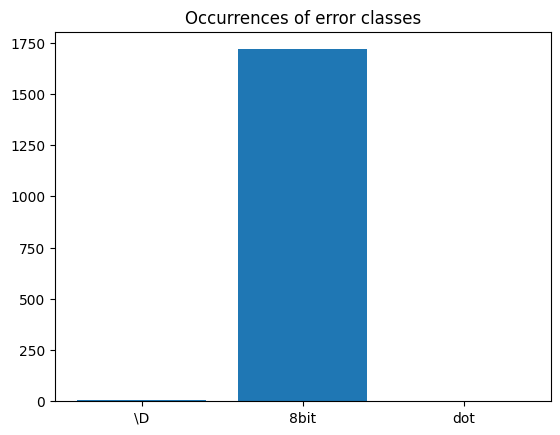

In [107]:
%matplotlib inline

ys = [troff_runner.no_backslash_d_failures,
      troff_runner.no_8bit_failures,
      troff_runner.no_dot_failures]

import matplotlib.pyplot as plt
plt.bar(["\\D", "8bit", "dot"], ys)
plt.title("Occurrences of error classes");

Again, we can see that some inputs (such as the single dot) are very improbable.

### Exercise 3: Run Real Troff

Using `BinaryProgramRunner`, apply the fuzzer you configured on the real `troff` program.  Check if you can produce any run whose output code is non-zero, indicating a failure or a crash.

**Solution.** This is just a matter of putting pieces together.

In [108]:
real_troff_runner = BinaryProgramRunner("troff")
for i in range(100):
    result, outcome = random_fuzzer.run(real_troff_runner)
    if outcome == Runner.FAIL:
        print(result)

Unfortunately, it is very unlikely that you'll find a bug in `troff` at this point.  Like most other open source code, it has been fuzzed this way before – and all errors found are already fixed.